In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# The aim of this notebook is to do an exploratory data analysis of health insurance data, and then use a linear regression model to be able to predict health insurance charges.

* An exploratory data analysis
* An example of univariate linear regression from scratch
* A multivariate linear regression from scratch
* Linear regression using the normal equation method
* Feature engineering
* Linear regression using scikit-learn
* Model validation

## The exploratory data analysis

In [2]:
df = pd.read_csv('insurance.csv')
print(df.head())
print(df.info())
print(df.isnull().sum())
print(df['region'].unique())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges

The data given is quite a small data-set with only 1338 people. There are a set of features describing the age, sex, bmi and reigion for each instance, as well as information on the number of children and whether they are a smoker or not. There are four categories in the region: southeast, southwest, northeast and northwest. The data is completely clean with no typos or missing data.

This is all compared against the charges on the health insurance.

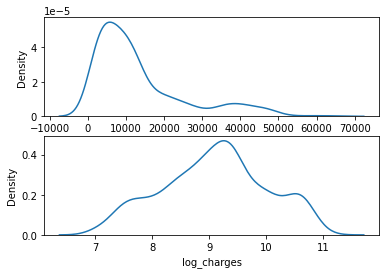

In [3]:
df['log_charges'] = np.log(df['charges'])

fig, ax = plt.subplots(nrows=2)
sns.distplot(df['charges'], ax=ax[0], hist=False)#.set_title('charges')
sns.distplot(df['log_charges'], ax=ax[1], hist=False)#.set_title('log charges')
plt.show()

The distribution of the charges shows a the data is positively skewed. When the log is taken, the data looks much better. The presence of peaks in the distribution suggests to me there are groups within the instances.

In [4]:
print('bmi correlation - ', df['charges'].corr(df['bmi']))
print('age correlation - ', df['charges'].corr(df['age']))

bmi correlation -  0.19834096883362892
age correlation -  0.29900819333064765


There is a significant correlation between both bmi and age with charges. I am slightly surprised at how low the correlation is though, especially with bmi which I would have thought would have a significant effect on health. I will look into why this is later.

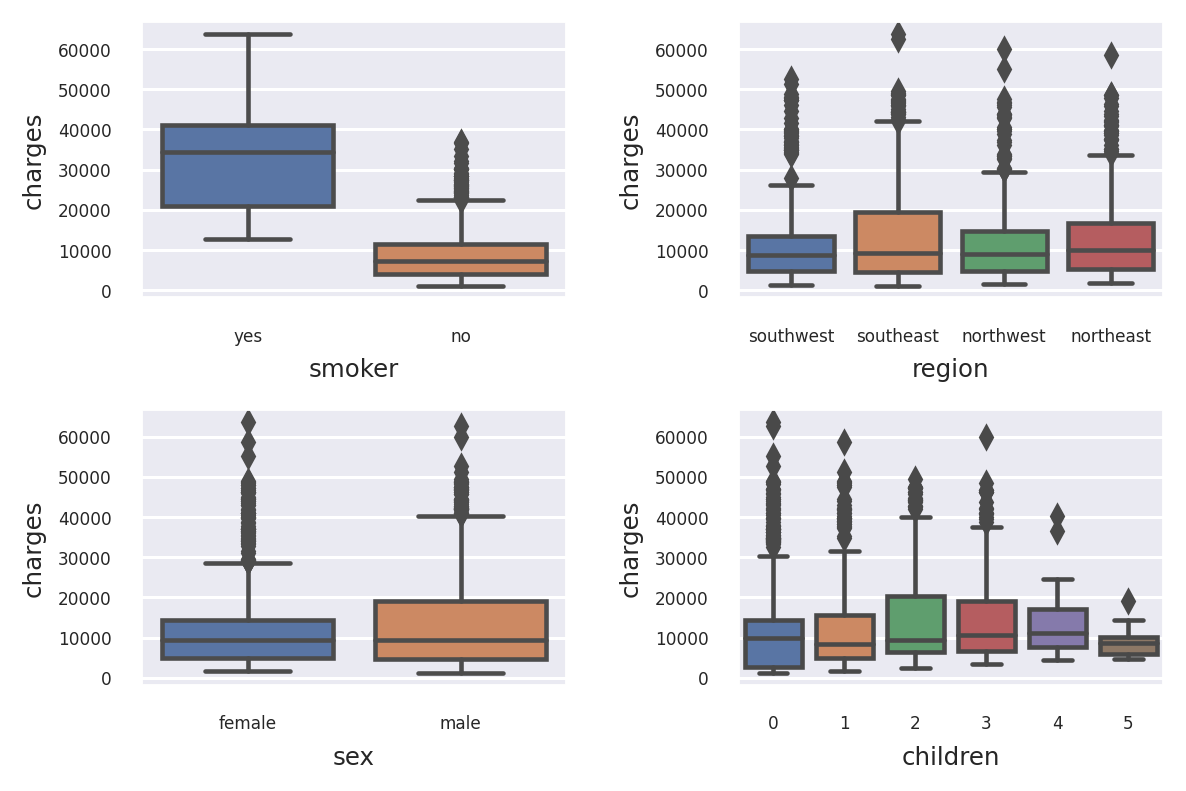

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


In [5]:
sns.set(font_scale = 0.5)

fig = plt.figure(dpi=220)
plt.rcParams["axes.labelsize"] = 8
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(data=df, x='smoker', y='charges', ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(data=df, x='region', y='charges', ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.boxplot(data=df, x='sex', y='charges', ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.boxplot(data=df, x='children', y='charges', ax=ax)
plt.show()
sns.set(font_scale = 1)

print(df['children'].value_counts())

With the categorical data, it is clear the biggest correlation to charges is with smoking. There appears to be some correlation with sex and region but not large. The number of children seems to have some effect on the charges but I am not sure how significant it is. Firstly the number of instances with 4 or 5 children is very low so I would not trust that data. Secondly, the 0 children category does not seem to fit an overall trend. I would therefore split this category up for a linear regresssion analysis into its contituent categories, rather than least it as an ordinal feature (0-5).

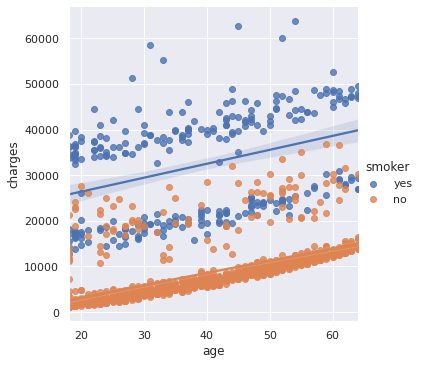

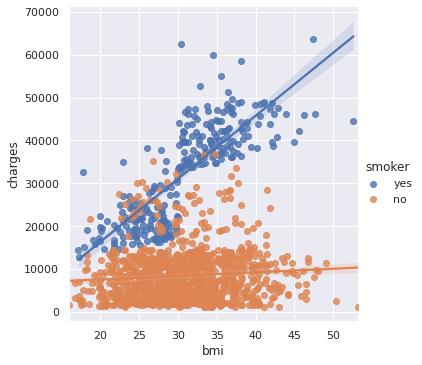

In [6]:
sns.lmplot(data=df, x='age', y='charges', hue='smoker')
plt.show()
sns.lmplot(data=df, x='bmi', y='charges', hue='smoker')
plt.show()

The scatter plot of age and charges shows there is an obvious distinction with how the smoking and non-smoking instances are treated. The smokers appear to be split again into another two groups while the non-smoking is probably all one group but with a set of outliers. These will probably be due to some other health concerns and is probably mirrored in in the smoking group; you can see the set of outliers at the top of the plot.

The scatter plot of bmi against charges shows this distinction between smokers and non-smokers again. Here though we see how the smoker group is subdivided: those with below and those with above a bmi of 30. There does not appear to be the same distinction for non-smokers. We cannot see from these plots what would cause the particularly high charges in some instances.

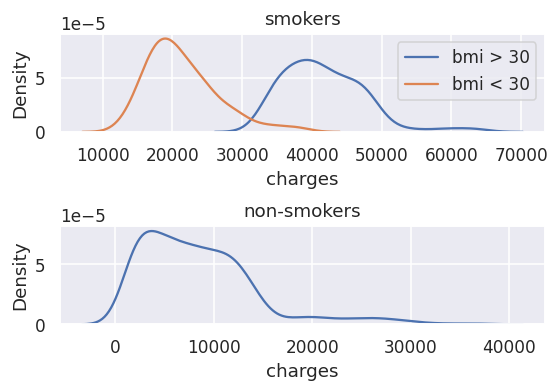

In [7]:
fig, ax = plt.subplots(nrows=2, dpi=110)
fig.tight_layout(pad=3.0)
sns.distplot(df[(df['smoker'] == 'yes') & (df['bmi'] > 30)]["charges"], ax=ax[0], hist=False,
             label='bmi > 30').set_title('smokers')
sns.distplot(df[(df['smoker'] == 'yes') & (df['bmi'] < 30)]["charges"], ax=ax[0], hist=False, label='bmi < 30')
sns.distplot(df[(df['smoker'] == 'no')]["charges"], ax=ax[1], hist=False).set_title('non-smokers')
ax[0].legend()
plt.show()

With this knowledge in mind we can now show the distribution of charges but split it into our three easily defined groups: non-smokers, smokers with bmi > 30 and smokers with bmi <30. As predicted there is a tail on some of the peak which we can see on the above scatter plots as (outlier) although it is very consistent so these will be for some medical reason. Interestingly, the same tail does not exist in the smokers with bmi < 30.

We will inesitigate whether one of the other features can account for these instances later.

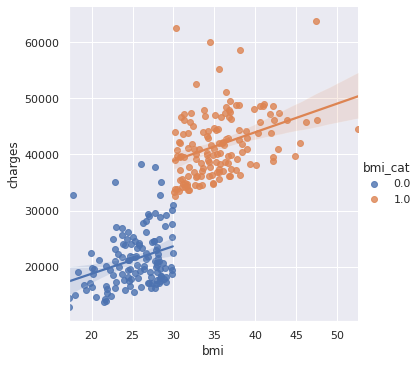

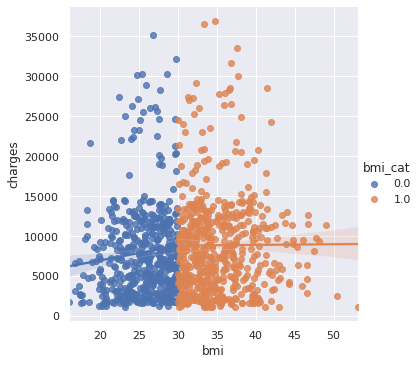

In [8]:
df['bmi_cat'] = np.nan
df.loc[df['bmi'] < 30, 'bmi_cat'] = 0
df.loc[df['bmi'] > 30, 'bmi_cat'] = 1

sns.lmplot(data=df[df['smoker'] == 'yes'], x='bmi', y='charges', hue='bmi_cat')
plt.show()
sns.lmplot(data=df[df['smoker'] == 'no'], x='bmi', y='charges', hue='bmi_cat')
plt.show()

It seems important to split the smokers and non-smokers into different groups to fit a line trhough them. The comparison to the above lmplot with them combined shows a completely different gradient of the line of best fit. We can see that actually having a bmi of over 30 doesnt change the gradiant but the bias is significantly increased. 

Finally, we confirm that there is no split of the non-smokers along the bmi = 30 line

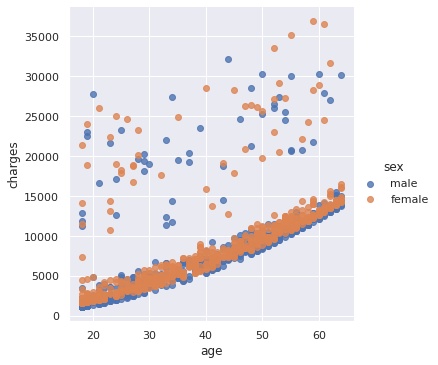

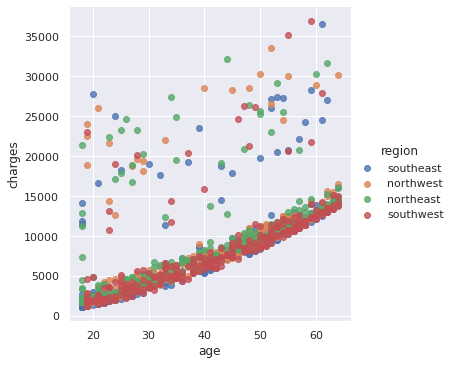

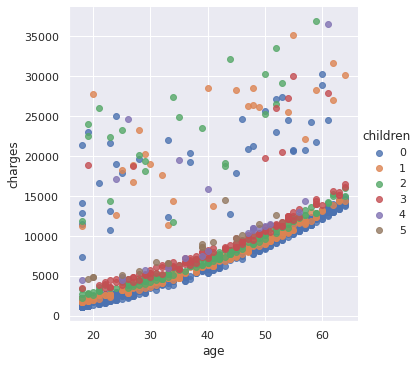

In [9]:
sns.lmplot(data=df[df['smoker'] == 'no'], x='age', y='charges', hue='sex', fit_reg=False)
plt.show()
sns.lmplot(data=df[df['smoker'] == 'no'], x='age', y='charges', hue='region', fit_reg=False)
plt.show()
sns.lmplot(data=df[df['smoker'] == 'no'], x='age', y='charges', hue='children', fit_reg=False)
plt.show()

Here we are looking for a reason for the unusually high charges on some instances. We have taken the non-smokers but can find no correlation between any of our remaining features. This suggests a medical reason which is not in our data. We therefor will not be able to model this and it will certainly cause some error in our final model. However, the number of instances and the spread is far to consistent to assume these are outliers and remove them.

In [10]:
print('bmi correlation (smokers) - ', df[df['smoker'] == 'yes']['charges'].corr(df['bmi']), '\n')
print('bmi correlation (smokers & bmi > 30) - ', 
      df[(df['smoker'] == 'yes') & (df['bmi'] > 30)]["charges"].corr(df['bmi']))
print('bmi correlation (smokers & bmi < 30) - ', 
      df[(df['smoker'] == 'yes') & (df['bmi'] > 30)]['charges'].corr(df['bmi']), '\n')
print('bmi correlation (non-smokers) - ', df[(df['smoker'] == 'no')]['charges'].corr(df['bmi']))
print('age correlation (smokers) - ', df[df['smoker'] == 'yes']['charges'].corr(df['age']))
print('age correlation (non-smokers) - ', df[(df['smoker'] == 'no')]['charges'].corr(df['age']))

bmi correlation (smokers) -  0.8064806070155404 

bmi correlation (smokers & bmi > 30) -  0.3650624941873683
bmi correlation (smokers & bmi < 30) -  0.3650624941873683 

bmi correlation (non-smokers) -  0.08403654312833268
age correlation (smokers) -  0.3682244437307778
age correlation (non-smokers) -  0.6279467837664195


We can now see correlations for our groups. As indicated earlier, the correlation between bmi and charges for smokers is probably not so large but just has a shift upwards at bmi=30. Interestingly we see almost no correlatino between charges and bmi for non-smokers.

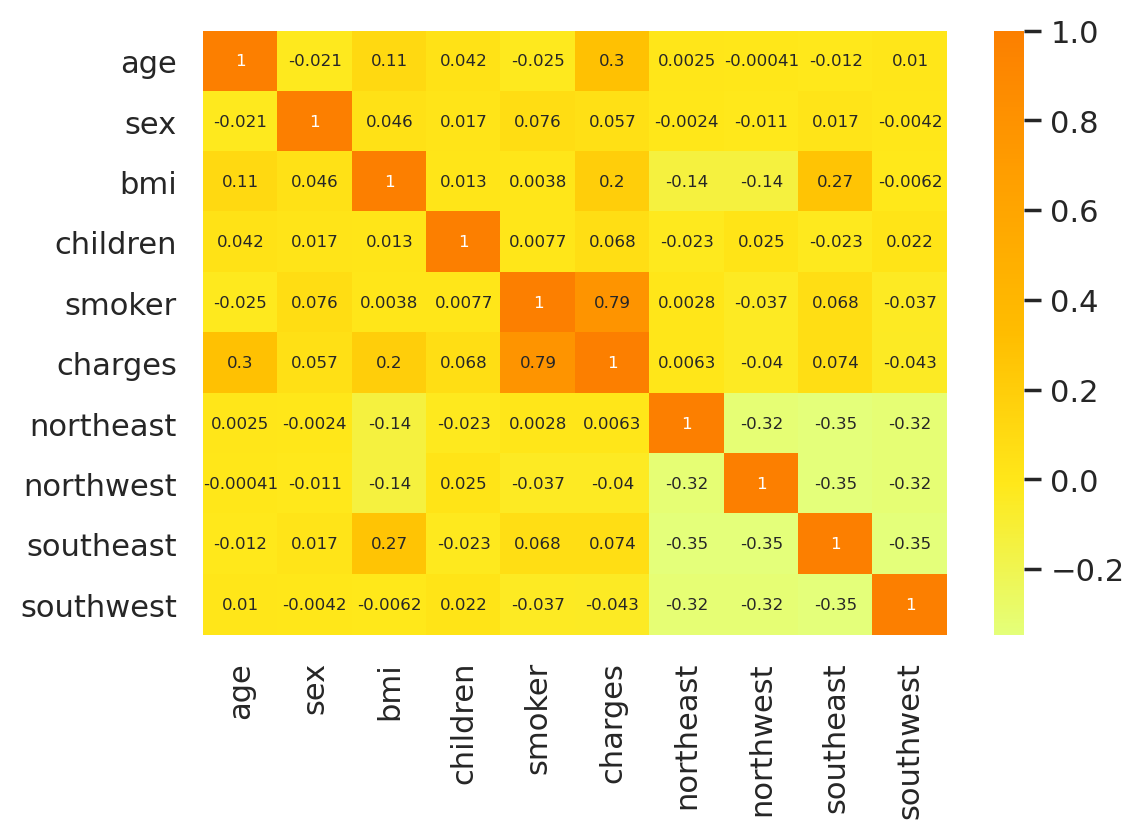

In [11]:
df['smoker'].replace(('yes', 'no'), (1, 0), inplace=True)
df['sex'].replace(('male', 'female'), (1, 0), inplace=True)

dummies = pd.get_dummies(df['region'])
df = pd.concat((df, dummies), axis = 1)
df = df.drop('region', axis = 1)

df_corr = df.drop(['log_charges', 'bmi_cat'], axis = 1)
corr = df_corr.corr()
fig, ax = plt.subplots(dpi=200)
sns.heatmap(corr, cmap = 'Wistia', annot= True, ax=ax, annot_kws={"size": 6})
plt.show()

There are no large correlations with charges other than bmi, age and obviously smoker. Here we are also looking for correlations between the features. We see a correlation between people living in the southeast and bmi which we should look out for when buliding the model.

In [30]:
df_children = df[['charges', 'children']]

dummies_children = pd.get_dummies(df_children['children'])
df_children = pd.concat((df_children, dummies_children), axis = 1)
df_children = df_children.drop('children', axis = 1)

print('0 children - ', df_children['charges'].corr(df_children[0]))
print('1 children - ', df_children['charges'].corr(df_children[1]))
print('2 children - ', df_children['charges'].corr(df_children[2]))
print('3 children - ', df_children['charges'].corr(df_children[3]))
print('4 children - ', df_children['charges'].corr(df_children[4]))
print('5 children - ', df_children['charges'].corr(df_children[5]))

0 children -  -0.06476047639409546
1 children -  -0.025180354353601806
2 children -  0.06963892513022256
3 children -  0.06279529451603874
4 children -  0.006613915717664698
5 children -  -0.04325837294882492


There are some slight correlations between the number of children and charges but no overall trend so we were right to split this feature up.

## Univariate linear regression from scratch

Now I will demonstrate linear regression with just one variable from scratch. In this case we will choose a feature that we know has good correlation with charges. We will therefore choose age for non-smokers.

In [12]:
def linear_func(X, th0, th1):
    return (X * th1) + th0

def cost_func(X, y, th0, th1):
    mm = len(X)
    return (1/2*mm) * np.sum(linear_func(X, th0, th1) - y)**2

def grad_descent_th0(X, y, alpha, th0, th1):
    mm = len(X)
    return (alpha / mm) * np.sum(linear_func(X, th0, th1) - y)

def grad_descent_th1(X, y, alpha, th0, th1):
    mm = len(X)
    return (alpha / mm) * np.sum((linear_func(X, th0, th1) - y)*X)

* The linear func is just the function for a line.
* The cost function gives us an indication of the accuracy of our linear function. It compares the generated y values (from the given x values) with the given y values. A cost of 0 would indicate a very good fit to the data.
* grad_descent_th0 is the partial derivative of the cost function with respect to theta0 and timesed by alpha (the learning rate).
* grad_descent_th1 is the partial derivative of the cost function with respect to theta1 and timesed by alpha (the learning rate).

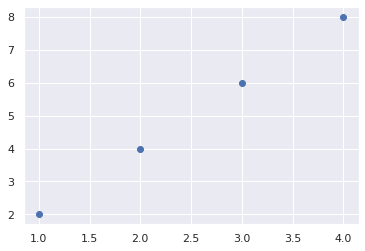

theta0 -  -4.9883369322054325e-06
theta1 -  2.000001696642868
final cost -  1.784337081835177e-11


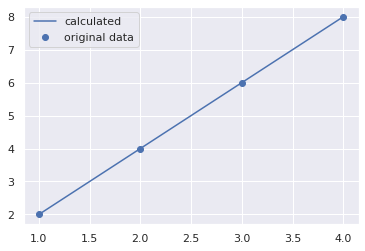

In [13]:
X = np.array([1,2,3,4])
y = np.array([2,4,6,8])

plt.scatter(X, y)
plt.show()

th0 = -15
th1 = 16
alpha = 0.1
loops = 1000

for ii in range(loops):
    temp_th0 = th0 - grad_descent_th0(X, y, alpha, th0, th1)
    temp_th1 = th1 - grad_descent_th1(X, y, alpha, th0, th1)
    th0 = temp_th0
    th1 = temp_th1
    
print('theta0 - ', th0)
print('theta1 - ', th1)
print('final cost - ', cost_func(X, y, th0, th1))

plt.plot(X, linear_func(X, th0, th1), label='calculated')
plt.scatter(X, y, label='original data')
plt.legend()
plt.show()

This demonstrates the linear regression algorithm on a very simple data set. The theta0 and theta1 values should be 0 and 2 respectively.

In [14]:
X = df[df['smoker'] == 0]['age'].values
y = df[df['smoker'] == 0]['charges'].values
print(df.head())
print(X[:5])
print(y[:5])

   age  sex     bmi  children  smoker      charges  log_charges  bmi_cat  \
0   19    0  27.900         0       1  16884.92400     9.734176      0.0   
1   18    1  33.770         1       0   1725.55230     7.453302      1.0   
2   28    1  33.000         3       0   4449.46200     8.400538      1.0   
3   33    1  22.705         0       0  21984.47061     9.998092      0.0   
4   32    1  28.880         0       0   3866.85520     8.260197      0.0   

   northeast  northwest  southeast  southwest  
0          0          0          0          1  
1          0          0          1          0  
2          0          0          1          0  
3          0          1          0          0  
4          0          1          0          0  
[18 28 33 32 31]
[ 1725.5523   4449.462   21984.47061  3866.8552   3756.6216 ]


To work with the health insurance data we have I have chosen a group of the data with a fairly good correlation and without obvious subgroups.

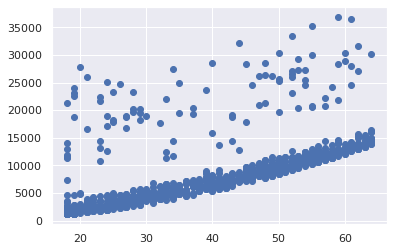

theta0 -  -2091.4205565630764
theta1 -  267.24891283115437
final cost -  3.1105060348416566e-11


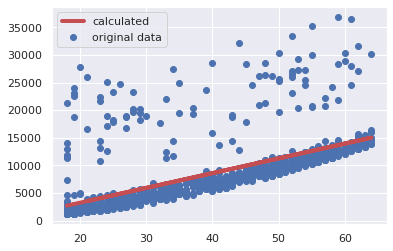

In [15]:
plt.scatter(X, y)
plt.show()

th0 = -15
th1 = 16
alpha = 0.001
loops = 1000000

for ii in range(loops):
    temp_th0 = th0 - grad_descent_th0(X, y, alpha, th0, th1)
    temp_th1 = th1 - grad_descent_th1(X, y, alpha, th0, th1)
    th0 = temp_th0
    th1 = temp_th1
    
print('theta0 - ', th0)
print('theta1 - ', th1)
print('final cost - ', cost_func(X, y, th0, th1))

plt.plot(X, linear_func(X, th0, th1), label='calculated', c='r', linewidth=4)
plt.scatter(X, y, label='original data', c='b')
plt.legend()
plt.show()

On this much larger and more varied dataset we still get a good fit to the data. It requires a much smaller learning rate and many more loops. It reamins to be seen if a linear fit is a good model for this data but at least the algorithm finds our line of best fit.

## Multivariate linear regression from scratch

We now go back to our full data set to use all of these features to create a linear regression model.